In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import uproot
import math
from scipy import optimize
import scipy
from kafe2 import HistContainer, Fit, Plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from struct import pack, unpack
from fitter import Fitter, get_common_distributions
import mplhep as hep
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import lmfit
import matplotlib as mpl

plt.style.use([hep.style.ROOT, hep.style.LHCb2])

In [ ]:
from shutil import which
from turtle import width
import json

def getSensorDataFromJSON(filename):
    data = []
    with open(filename) as file: data = json.load(file)
    return data

sensors = getSensorDataFromJSON("sensors_mapping.json")

viridis = cm.get_cmap('viridis', 3)
newcolors = viridis(np.linspace(0,1,4))
colors_bar = [
    (114 / 255, 147 / 255, 203 / 255, 1), # blue
    (225 / 255, 151 / 255, 76 / 255, 1),  # orange
    (132 / 255, 186 / 255, 91 / 255, 1),  # green
    (211 / 255, 94 / 255, 96 / 255, 1),   # red
    (128 / 255, 133 / 255, 133 / 255, 1), # black
    (144 / 255, 103 / 255, 167 / 255, 1), # purple
    (171 / 255, 104 / 255, 87 / 255, 1),  # wine
    (204 / 255, 194 / 255, 16 / 255, 1)   # gold
]
newcolors[0:1, :] = colors_bar[2]
newcolors[1:2, :] = colors_bar[1]
newcolors[2:3, :] = colors_bar[3]
newcolors[3:4, :] = colors_bar[4]
newcolors[4:5, :] = colors_bar[5]

newcmp = ListedColormap(newcolors)

A_L0 = np.zeros((8,6))
A_L1 = np.zeros((10,6))

# no hv
A_L0[0,0] = 1 # 0
A_L0[0,1] = 1 # 1
A_L0[0,2] = 1 # 2
A_L0[5,0] = 1 # 15
A_L0[5,1] = 1 # 16
A_L0[5,2] = 1 # 17
A_L0[7,3] = 1 # 83
A_L0[7,4] = 1 # 82
A_L0[7,5] = 1 # 81

A_L1[0,0] = 4 # 24
A_L1[0,1] = 1 # 25
A_L1[0,2] = 1 # 26
A_L1[1,0] = 1 # 27
A_L1[1,1] = 1 # 28
A_L1[1,2] = 1 # 29
A_L1[8,0] = 1 # 48
A_L1[8,1] = 1 # 49
A_L1[8,2] = 1 # 50
A_L1[0,3] = 1 # 86
A_L1[0,4] = 1 # 85
A_L1[0,5] = 1 # 84
A_L1[1,3] = 1 # 89
A_L1[1,4] = 1 # 88
A_L1[1,5] = 1 # 87
A_L1[2,3] = 1 # 92
A_L1[2,4] = 1 # 91
A_L1[2,5] = 1 # 90
A_L1[9,3] = 1 # 113
A_L1[9,4] = 1 # 112
A_L1[9,5] = 1 # 111
# bad from last run
A_L0[0,2] = 3 # 2
A_L0[1,0] = 2 # 3
A_L0[3,0] = 2 # 9
A_L0[3,1] = 2 # 10
A_L0[3,2] = 2 # 11
A_L0[4,1] = 2 # 13
A_L0[4,2] = 2 # 14
A_L0[5,0] = 3 # 15
A_L0[6,2] = 2 # 20
A_L0[7,1] = 2 # 22
A_L0[7,2] = 2 # 23
A_L0[0,3] = 2 # 62
A_L0[2,3] = 2 # 68
A_L0[3,5] = 2 # 69
A_L0[4,5] = 4 # 72
A_L0[7,3] = 4 # 83
A_L0[7,4] = 4 # 82
A_L0[7,5] = 4 # 81

A_L1[0,3] = 4 # 86
A_L1[0,4] = 4 # 85
A_L1[0,5] = 4 # 84
A_L1[1,0] = 4 # 27
A_L1[1,5] = 4 # 87
A_L1[2,0] = 2 # 30
A_L1[3,1] = 2 # 34
A_L1[3,3] = 2 # 95
A_L1[4,0] = 2 # 36
A_L1[4,1] = 2 # 37
A_L1[4,2] = 2 # 38
A_L1[4,3] = 2 # 98
A_L1[4,5] = 2 # 96
A_L1[5,1] = 4 # 40
A_L1[6,0] = 2 # 42
A_L1[6,3] = 2 # 104
A_L1[6,5] = 2 # 102
A_L1[7,2] = 2 # 47
A_L1[7,4] = 2 # 106
A_L1[8,0] = 4 # 48
A_L1[8,2] = 4 # 50
A_L1[8,3] = 2 # 110
A_L1[8,5] = 2 # 108
A_L1[9,0] = 2 # 51
A_L1[9,1] = 2 # 52
A_L1[9,2] = 2 # 53
A_L1[9,3] = 4 # 113
A_L1[9,3] = 4 # 112
A_L1[9,3] = 4 # 111

fig, (ax0, ax1) = plt.subplots(1,2, gridspec_kw={'wspace': 0.5})

# for sensorEntry in sensors:
#     sensor = sensors[sensorEntry]
#     chip = sensor["runChip"]
#     index = (sensor["localLadder"], sensor["ladderChip"])
    
#     layer = sensor["layer"]

#     bad_chip_tot = False
#     no_chip_hv = False
#     bad_chip_2021 = False
    
#     if chip in bad_chips_tot:
#         bad_chip_tot = True
#         if layer==0: A_L0[index] = 2
#         else: A_L1[index] = 2

#     if chip in no_hv:
#         no_chip_hv = True
#         if layer==0: A_L0[index] = 1
#         else: A_L1[index] = 1

#     if chip in bad_2021:
#         bad_chip_2021 = True
#         if layer==0: A_L0[index] = 2
#         else: A_L1[index] = 2

#     condition = [bad_chip_tot, no_chip_hv, bad_chip_2021]
#     if (condition.count(True) >= 2):
#         if layer==0: A_L0[index] = 4
#         else: A_L1[index] = 4

a0 = ax0.imshow(A_L0, cmap=newcmp)
a1 = ax1.imshow(A_L1, cmap=newcmp)

for sensorEntry in sensors:
    sensor = sensors[sensorEntry]
    detail = (sensor["ladderChip"], sensor["localLadder"], sensor["runChip"])
    if sensor["layer"] == 0: ax0.text(*detail, ha='center', va='center')
    else: ax1.text(*detail, ha='center', va='center')

ax0.set_aspect('equal')
ax1.set_aspect('equal')

plt.setp((ax0, ax1), xticks=[0,1,2,3,4,5], xlabel="Chip number", ylabel="Ladder ID")
plt.sca(ax0)
plt.yticks([0,1,2,3,4,5,6,7])
plt.title('Layer 0', y=1.03)
plt.sca(ax1)
plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.title('Layer 1', y=1.03)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(a1, ax=ax1, cax=cax, ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['Functional', 'No HV', 'Bad chip', 'Combination'])
cbar.ax.tick_params(size=0, which="both", labelsize=20)

ax0.tick_params(size=0)
ax1.tick_params(size=0)

ax1.set_xticks(np.arange(-.5, 5.5, 1), minor=True)
ax1.set_yticks(np.arange(-.5, 10.5, 1), minor=True)
ax1.grid(which='minor', color='k', linestyle='-', linewidth=2, alpha=1.0)

ax0.set_xticks(np.arange(-.5, 5.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, 7.5, 1), minor=True)
ax0.grid(which='minor', color='k', linestyle='-', linewidth=2, alpha=1.0)

fig.savefig("working_chips.pdf", bbox_inches='tight')

In [ ]:
def get_tot(ck1, ck2, ts1, ts2, ts_base, mask):
    return ((int(ts2)*(ck2+1)-int(ts1&mask)*(ck1+1)+(mask+1))&mask)*ts_base

def get_tot_value(ts1, ts2):
    nTS2bits = 5
    ckdividend1 = 0
    ckdividend2 = 0xF
    ts_base = 1

    # calculate mask
    mask = np.uint32(((np.uint32(2**nTS2bits) << np.int32(math.log2(1+ckdividend2))) >> np.int32(math.log2(1+ckdividend1))) - 1)
    return get_tot(ckdividend1, ckdividend2, ts1 % 2048, ts2, ts_base, mask)

def plot_helper_ax(ax, xlabel=r"Time $[\mu s]$", ylabel=r"Counts", title='Mu3e IntRun 2021', saveName='plots/helper', legend=False,
                loc='best', ncol=1, save=False):
    ax.set_xlabel(xlabel, loc='right')
    ax.set_ylabel(ylabel, loc='top')
    ax.set_title(title, loc='left')
    if legend:
        plt.legend(loc=loc, ncol=ncol)
    if save:
        plt.savefig(saveName + '.pdf')
        plt.savefig(saveName + '.png')
        plt.show()
    
def plot_helper(xlabel=r"Time $[\mu s]$", ylabel=r"Counts", title='Mu3e IntRun 2021', saveName='plots/helper', legend=False,
                loc='best', ncol=1, save=False):
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')
    plt.title(title, loc='left')
    if legend:
        plt.legend(loc=loc, ncol=ncol)
    if save:
        plt.savefig(saveName + '.pdf')
        plt.savefig(saveName + '.png')
        plt.show()

In [ ]:
# read data in
df = pd.read_csv("combinedTree.csv")

# get all differences
df["n_ts_scifi_trigger_diff"] = np.double((np.int32(df["n_ts_scifi"]) - np.int32(df["n_ts_trigger"]*5)) * 1.6)
df["n_ts_trigger_scifi_diff"] = np.double((np.int32(df["n_ts_scifi"]) - np.int32(df["n_ts_trigger"]*5)) * 1.6)
df["n_ts_pixel_trigger_diff"] = np.double((np.int32(df["n_ts_pixel"]) - np.int32(df["n_ts_trigger"])) * 8)
df["n_ts_trigger_pixel_diff"] = np.double((np.int32(df["n_ts_pixel"]) - np.int32(df["n_ts_trigger"])) * 8)
df["n_ts_scifi_pixel_diff"] = np.double((np.int32(df["n_ts_scifi"]) - np.int32(df["n_ts_pixel"]*5)) * 1.6)
df["n_ts_pixel_scifi_diff"] = np.double((np.int32(df["n_ts_scifi"]) - np.int32(df["n_ts_pixel"]*5)) * 1.6)

# exclude bad chips
ohm_370 = [97,43,44,103,45,46,107,105,109]
badL0 = [0,1,2,63,3,68,9,10,11,69,13,14,72,15,16,17,20,22,23,83,82,81]
badL1 = [24,25,26,86,85,84,27,28,29,89,88,87,30,92,91,90,34,95,36,37,38,98,96,40,42,104,102,47,106,48,49,50,110,108,51,52,53,113,112,111]
for chip in badL0:
    df = df.drop(df[df.n_chipID == chip].index)
for chip in badL1:
    df = df.drop(df[df.n_chipID == chip].index)

In [ ]:
df

In [ ]:
# correction for tot pixel
cut = (df["n_ts_pixel_trigger_diff"] < 1000) & (df["n_ts_pixel_trigger_diff"] > -1000) & (df["n_col"] < 236)
tot_correction = []
tot_correction_per_chip = []
tot_mean_correction_per_chip = []
tot_hist_per_chip = {}
tot_mean_hist_per_chip = {}
for chip in np.unique(df["n_chipID"]):
    for ts2 in np.unique(df["n_ts2"]):
        cut3 = cut & (df["n_ts2"] == ts2) & (df["n_chipID"] == chip)
        (n, bins, _) = plt.hist(df[cut3]["n_ts_pixel_trigger_diff"])#, bins=100)
        # the timewalk corrections is realized by shifting the TS1-t_ref distributions for 
        # individual ToT bins by the value of the TS1-t_ref bin with the maximum number of entries
        tot_hist_per_chip["{}-{}".format(chip, ts2)] = bins[n.argmax()]
        tot_mean_hist_per_chip["{}-{}".format(chip, ts2)] = np.mean(df[cut3]["n_ts_pixel_trigger_diff"])
for chip, ts2 in zip(df["n_chipID"], df["n_ts2"]):
    #cut2 = cut & (df["n_ts2"] == ts2)
    #tot_correction.append(np.mean(df[cut2]["n_ts_pixel_trigger_diff"]))
    tot_mean_correction_per_chip.append(tot_mean_hist_per_chip["{}-{}".format(chip, ts2)])
    tot_correction_per_chip.append(tot_hist_per_chip["{}-{}".format(chip, ts2)])

In [ ]:
#df["tot_correction"] = tot_correction
df["tot_correction_per_chip"] = tot_correction_per_chip
df["tot_mean_correction_per_chip"] = tot_mean_correction_per_chip
df["tot"] = [get_tot_value(ts1, ts2) for ts1, ts2 in zip(df["n_ts_pixel"], df["n_ts2"])]
#df["n_diff_trigger_corrected"] = df["n_ts_pixel_trigger_diff"] - df["tot_correction_per_chip"]
df["n_diff_trigger_corrected"] = df["n_ts_pixel_trigger_diff"] - df["tot_mean_correction_per_chip"]

In [ ]:
# plot ToT correction pixel
# fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
# im0 = ax[0].hist2d(df[cut]["n_ts_pixel_trigger_diff"], df[cut]["tot"], bins=[100, 32], rasterized=True)
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im0[3], cax=cax, orientation='vertical')
# plot_helper_ax(xlabel=r"$t_{pixel}$ - $t_{trigger}$ [ns]", 
#                ylabel=r"ToT",
#                title='ToT vs. $t_{pixel}$ - $t_{trigger}$',
#                ax=ax[0]
#               )
# im1 = ax[1].hist2d(df[cut]["n_diff_trigger_corrected"], df[cut]["tot"], bins=[100, 32], rasterized=True)
# plot_helper_ax(xlabel=r"$t_{pixel}$ - $t_{trigger}$ [ns]", 
#                ylabel=r"ToT",
#                title=r'ToT vs. $t_{pixel}$ - $t_{trigger}$ (corrected)',
#                ax=ax[1]
#               )
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1[3], cax=cax, orientation='vertical')
# plt.subplots_adjust(right=0.9,
#                     top=0.9,
#                     wspace=0.35,
#                     hspace=0.45)
# plt.savefig("timewalk1.pdf")
# plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
# nbins_trigger = int(np.sqrt(len(df[cut]["n_ts_pixel_trigger_diff"])))
# ax[0].hist(df[cut]["n_ts_pixel_trigger_diff"], bins=40)
# plot_helper_ax(xlabel=r"$t_{pixel}$ - $t_{trigger}$ [ns]", 
#                ylabel=r"Counts",
#                title='$t_{pixel}$ - $t_{trigger}$',
#                ax=ax[0]
#               )
# ax[1].hist(df[cut]["n_diff_trigger_corrected"], bins=40)
# plot_helper_ax(xlabel=r"$t_{pixel}$ - $t_{trigger}$ [ns]", 
#                ylabel=r"Counts",
#                title='$t_{pixel}$ - $t_{trigger}$ (corrected)',
#                ax=ax[1]
#               )
# plt.subplots_adjust(right=0.9,
#                     top=0.9,
#                     wspace=0.35,
#                     hspace=0.45)
# plt.savefig("timewalk2.pdf")
# plt.show()

In [ ]:
# plot ToT correction pixel
# fig, ax = plt.subplots(2, 1, constrained_layout=True)
# im0 = ax[0].hist2d(df[cut]["n_ts_pixel_trigger_diff"], df[cut]["tot"], bins=[100, 32], rasterized=True)
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im0[3], cax=cax, orientation='vertical')
# plot_helper_ax(xlabel=r"$T_{pixel}$ - $T_{trigger}$ [ns]", 
#             ylabel=r"ToT [ns]",
#             title='',
#             ax=ax[0]
# )
# im1 = ax[1].hist2d(df[cut]["n_diff_trigger_corrected"], df[cut]["tot"], bins=[100, 32], rasterized=True)
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1[3], cax=cax, orientation='vertical')
# plot_helper_ax(xlabel=r"$T_{pixel}$ - $T_{trigger}$ [ns]", 
#             ylabel=r"ToT [ns]",
#             title=r'',
#             ax=ax[1]
# )
# # plt.subplots_adjust(right=0.9,
# #                     top=0.99,
# #                     wspace=0.35,
# #                     hspace=0.45)
# plt.savefig("timewalk.pdf")
# plt.show()

fig, ax = plt.subplots(1, 2)
nbins_trigger = int(np.sqrt(len(df[cut]["n_ts_pixel_trigger_diff"])))
ax[0].hist(df[cut]["n_ts_pixel_trigger_diff"], bins=40)
plot_helper_ax(xlabel=r"$T_{Pixel}$ - $T_{Trigger}$ [ns]", 
               ylabel=r"Counts",
               title='Uncorrected',
               ax=ax[0]
              )
ax[1].hist(df[cut]["n_diff_trigger_corrected"], bins=40)
plot_helper_ax(xlabel=r"$T_{Pixel}$ - $T_{Trigger}$ [ns]", 
               ylabel=r"Counts",
               title='Corrected',
               ax=ax[1]
              )
# plt.subplots_adjust(right=0.9,
#                     top=0.9,
#                     wspace=0.35,
#                     hspace=0.45)
plt.savefig("timewalk2.pdf")
plt.show()

In [ ]:
# check for tot correction in scifi
cut2 = cut & (df["n_ts_scifi_trigger_diff"] < 400) & (df["n_ts_scifi_trigger_diff"] > -400)
fig, ax = plt.subplots(1, 2)
im0 = ax[0].hist(df[cut2]["n_ts_scifi_trigger_diff"], bins=100)
plot_helper_ax(xlabel=r"$t_{scifi}$ - $t_{trigger}$ [ns]", 
               ylabel=r"Counts",
               title='$t_{scifi}$ - $t_{trigger}$',
               ax=ax[0]
              )
im1 = ax[1].hist2d(df[cut2]["n_ts_scifi_trigger_diff"], df[cut2]["tot"], bins=[100, 32])
plot_helper_ax(xlabel=r"$t_{scifi}$ - $t_{trigger}$ [ns]", 
               ylabel=r"Pixel ToT",
               title=r'Pixel ToT vs. $t_{scifi}$ - $t_{trigger}$',
               ax=ax[1]
              )
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1[3], cax=cax, orientation='vertical')
# plt.subplots_adjust(right=0.9,
#                     top=0.9,
#                     wspace=0.35,
#                     hspace=0.45)
plt.show()

In [ ]:
# get scifi pixel difference
df["n_diff_pixel_scifi"] = df["n_diff_trigger_corrected"] - df["n_ts_scifi_trigger_diff"]
df["n_diff_pixel_scifi_corrected"] = df["n_diff_pixel_scifi"]-(np.mean(df[cut2]["n_diff_pixel_scifi"]))

In [ ]:
# find best fit model
f = Fitter(df[cut2]["n_diff_pixel_scifi_corrected"], distributions=get_common_distributions())
f.fit()
print(f.summary(), f.get_best(method = 'sumsquare_error'), f.bins, f.fitted_param['norm'])
plt.show()

# show histo
nbins = f.bins
(n, bins, _) = plt.hist(df[cut2]["n_diff_pixel_scifi_corrected"], bins=nbins, density=True)

# plot fitted function
function = "norm"
if function == "cauchy":
    dist = scipy.stats.cauchy
    param = [f.fitted_param['cauchy'][0], f.fitted_param['cauchy'][1]]
if function == "norm":
    dist = scipy.stats.norm
    param = [f.fitted_param['norm'][0], f.fitted_param['norm'][1]]
x = np.linspace(-400, 400, 100)
pdf_fitted = dist.pdf(x, *param)
plt.plot(x, pdf_fitted, '-')
plt.show()

In [ ]:
# fit time correlation between pixel and scifi
def normal_distribution(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / np.sqrt(2.0 * np.pi * sigma ** 2)
def BreitWigner(E, s0=41.0, M=91.2, G=2.5):
    return s0*E*E*G*G/((E*E-M*M)**2+(E**4*G*G/(M*M)))
def background(x, c, d):
    # since we had no track information present we readout all trigger hits
    # and all pixel hits in a moving time frame of 8000ns resulting in a triangular-shaped
    # background for the TS1-t_ref distribution. This is a accounted by adding
    # c(d-|x|) to the fit function gaussian, where c is the scaling parameter and d
    # is the maximum difference between TS1 and t_ref
    return c*(d-abs(x))
def fit_function(x, mu, sigma, c, d):
    return normal_distribution(x, mu, sigma) + background(x, c, d)
def fit_function2(E, s0, M, G, c, d):
    return BreitWigner(E, s0, M, G) + background(x, c, d)
def residual(p, x, y):
    return fit_function(x, *p) - y

# show histo
nbins = 40
ohm_370_cut = cut2 & df["n_chipID"].isin(ohm_370)
ohm_20_cut = cut2 & ~df["n_chipID"].isin(ohm_370)

# plt.hist(df[ohm_20_cut]["n_diff_pixel_scifi_corrected"], bins=30, range=(-400,400))
# plt.hist(df[ohm_370_cut]["n_diff_pixel_scifi_corrected"], bins=30, range=(-400,400))
# plt.show()
for cuti, nbins, cut_type in zip([cut2, ohm_370_cut, ohm_20_cut], [30, 30, 30], ["all", "highResistance", "lowResistance"]):
    (n, bins, _) = plt.hist(df[cuti]["n_diff_pixel_scifi_corrected"], bins=nbins, density=True)
    plt.close()
    # generate data from bins as a set of points 
    bin_size = abs(bins[1] - bins[0])
    x = np.linspace(start=bins[0]+bin_size/2.0, stop=bins[-2]+bin_size/2.0, num=nbins, endpoint=True)
    y = n
    y[y==0]= 1e-8

    # fit
    initGuess = [24, 50, 1, 200]
    popt, pcov = optimize.curve_fit(fit_function, x, y, p0=initGuess)#default-> use sigma=1 sigma=np.sqrt(np.var(y))) 
    perr = np.sqrt(np.diag(pcov))
    #print(popt, perr)

    # fit with lmfit
    model = lmfit.Model(fit_function, independent_vars=('x'))
    param_values = dict(x=x, mu=0, sigma=100, c=0, d=350)
    result = model.fit(n, **param_values)
    #print(result.fit_report())
    #print(dir(result), result.chisqr, result.redchi)
    popt = [result.best_values[k] for k in result.best_values.keys()]

    # Plot the fit
    (n_false, binsv_false, _) = plt.hist(df[cuti]["n_diff_pixel_scifi_corrected"], bins=nbins)
    plt.close()
    scale = n_false/n
    x_fit = np.linspace(x[0], x[-1], nbins)
    y_gauss = normal_distribution(x_fit, popt[0], popt[1])
    y_triangular = background(x_fit, popt[2], popt[3])

    fig = plt.figure(constrained_layout=True)
    ax0 = fig.add_axes((.1,.3,.8,.58))
    ax0.set_ylabel("Counts")
    ax0.set_xticklabels([]) 
    ax0.tick_params(bottom = False)
    hep.histplot(n_false, binsv_false, yerr=True, label="Data")

    chi = str(round(result.chisqr,7)).split("e")
    c = str(round(popt[2],7)).split("e")
    cerr = str(round(perr[2],7)).split("e")
    plt.plot(
        x_fit, (y_gauss+y_triangular)*scale, linestyle='--', linewidth=3, color='red', 
        label='Gaussian + Triangular'
    )

    plt.plot([], [], ' ', label='$\mu={}\pm{}$ ns\n$\sigma={}\pm{}$ ns\n$c={}\cdot10^{}\pm{}\cdot10^{}$\n$d={}\pm{}$\n$\chi^2/\\nu={}\cdot10^{}/{}$'.format(
        round(popt[0],1), round(perr[0],1),
        round(popt[1],1), round(perr[1],1),
        int(round(float(c[0]),0)), "{"+str(int(c[1]))+"}",
        int(round(float(cerr[0]))), "{"+str(int(cerr[1]))+"}",
        round(popt[3],1), round(perr[3],1),
        float(chi[0]), "{"+str(int(chi[1]))+"}",
        int(result.chisqr/result.redchi)
    ))
    #plt.plot(x_fit, y_triangular*scale)

    # Residual plot
    difference = n_false - y_gauss*scale
    ax1 = fig.add_axes((.1,.1,.8,.19))
    ax1.plot(binsv_false[:-1], [0 for i in  binsv_false[:-1]], c=colors_bar[4])
    ax1.plot(binsv_false[:-1], [15 for i in binsv_false[:-1]], c=colors_bar[4], ls="--")
    ax1.plot(binsv_false[:-1], [-15 for i in binsv_false[:-1]], c=colors_bar[4], ls="--")
    ax1.step(binsv_false[:-1], difference, c="black")

    ax1.set_ylabel("Fract. Dev.")
    ax1.set_xlabel(r"$T_{Pixel}$ - $T_{Scifi}$ [ns]")

    ax0.legend(loc="best", fontsize=22)#, fontsize=7.9)
    plt.savefig(f"pixel-scifi-time-{cut_type}.pdf") 
    plt.show()
# we have three systematic error: scifi +- xns, pixel +- 8ns, trigger +- 8ns

In [ ]:
# get errors from trigger diff
nbins_trigger=40
#### Fit Pixel ####
(n, bins, _) = plt.hist(df[cut]["n_diff_trigger_corrected"], bins=nbins_trigger, density=True)
plt.close()

# generate data from bins as a set of points 
bin_size = abs(bins[1] - bins[0])
x = np.linspace(start=bins[0]+bin_size/2.0, stop=bins[-2]+bin_size/2.0, num=nbins_trigger, endpoint=True)
y = n
y[y==0]= 1e-8

# fit
initGuess = [24, 50, 1, 200]
popt, pcov = optimize.curve_fit(fit_function, x, y, p0=initGuess)#default-> use sigma=1
perr = np.sqrt(np.diag(pcov))

# Plot the fit
(n_false, binsv_false, _) = plt.hist(df[cut]["n_diff_trigger_corrected"], bins=nbins_trigger)
plt.close()
scale = n_false/n
x_fit = np.linspace(x[0], x[-1], nbins_trigger)
y_gauss = fit_function(x_fit, *popt)
#plt.errorbar(n_false, binsv_false, yerr=np.sqrt(binsv_false), linestyle="", marker="", color="gray", alpha=0.3)
hep.histplot(n_false, binsv_false, yerr=True, label="data")

plt.plot(
    x_fit, y_gauss*scale, linestyle='--', linewidth=2, color='red', 
    label='Gaussian + Triangular\n$\mu={}\pm{}, \sigma={}\pm{},$\n$c={}\pm{}, d={}\pm{}$'.format(
    round(popt[0],1), round(perr[0],1),
    round(popt[1],1), round(perr[1],1),
    round(popt[2],1), round(perr[2],1),
    round(popt[3],1), round(perr[3],1),
    )
)
plt.legend(loc="upper right")
plot_helper(
    xlabel=r"$t_{pixel}$ - $t_{trigger}$ [ns]", 
    ylabel=r"#",
    title=r'$t_{pixel}$ - $t_{trigger}$ (corrected)',
)
plt.show()

#### Fit Scifi ####
cut2 = cut & (df["n_ts_scifi_trigger_diff"] < 400) & (df["n_ts_scifi_trigger_diff"] > -400)
(n, bins, _) = plt.hist(df[cut2]["n_ts_scifi_trigger_diff"], bins=nbins_trigger, density=True)
plt.close()

# generate data from bins as a set of points 
bin_size = abs(bins[1] - bins[0])
x = np.linspace(start=bins[0]+bin_size/2.0, stop=bins[-2]+bin_size/2.0, num=nbins_trigger, endpoint=True)
y = n
y[y==0]= 1e-8

# fit
initGuess = [24, 50, 1, 200]
popt, pcov = optimize.curve_fit(fit_function, x, y, p0=initGuess)#default-> use sigma=1
perr = np.sqrt(np.diag(pcov))

# Plot the fit
(n_false, binsv_false, _) = plt.hist(df[cut2]["n_ts_scifi_trigger_diff"], bins=nbins_trigger)
plt.close()
scale = n_false/n
x_fit = np.linspace(x[0], x[-1], nbins_trigger)
y_gauss = fit_function(x_fit, *popt)
#plt.errorbar(n_false, binsv_false, yerr=np.sqrt(binsv_false), linestyle="", marker="", color="gray", alpha=0.3)
hep.histplot(n_false, binsv_false, yerr=True, label="data")

plt.plot(
    x_fit, y_gauss*scale, linestyle='--', linewidth=2, color='red', 
    label='Gaussian + Triangular\n$\mu={}\pm{}, \sigma={}\pm{},$\n$c={}\pm{}, d={}\pm{}$'.format(
    round(popt[0],1), round(perr[0],1),
    round(popt[1],1), round(perr[1],1),
    round(popt[2],1), round(perr[2],1),
    round(popt[3],1), round(perr[3],1),
    )
)
plt.legend(loc="upper right")
plot_helper(
    xlabel=r"$t_{scifi}$ - $t_{trigger}$ [ns]", 
    ylabel=r"#",
    title=r'$t_{scifi}$ - $t_{trigger}$',
)
plt.show()

In [ ]:
# Plot global col/row vs channel within time res

# centred on -8 +/- 100 ns

spat_corr_cut = cut2 & (df["n_diff_pixel_scifi_corrected"] < 92) & (df["n_diff_pixel_scifi_corrected"] > -108) & (df["n_asic_scifi"] != 15)

def globalCol(chipID, col):
    return chipID * 256 + col

def globalRow(chipID, row):
    return chipID * 250 + row

def globalChannel(asicID, ch):
    return asicID * 32 + ch

df["global_col"] = [globalCol(chipID, col) for chipID, col in zip(df["n_chipID"], df["n_col"])]
df["global_row"] = [globalRow(chipID, row) for chipID, row in zip(df["n_chipID"], df["n_row"])]
df["global_ch"] = [globalChannel(asicID, ch) for asicID, ch in zip(df["n_asic_scifi"], df["n_ch_scifi"])]

print(df[spat_corr_cut]["n_asic_scifi"].max(), np.unique(df[spat_corr_cut]["n_asic_scifi"]), len(df[spat_corr_cut]["n_asic_scifi"]))

In [ ]:

cdict = {
    'red': (
        (0.00, 0.00, 0.00),
        (0.34, 0.00, 0.00),
        (0.61, 0.87, 0.87),
        (0.84, 1.00, 1.00),
        (1.00, 0.51, 0.51)
    ),
    'green': (
        (0.00, 0.00, 0.00),
        (0.34, 0.81, 0.81),
        (0.61, 1.00, 1.00),
        (0.84, 0.20, 0.20),
        (1.00, 0.00, 0.00)
    ),
    'blue': (
        (0.00, 0.51, 0.51),
        (0.34, 1.00, 1.00),
        (0.61, 0.12, 0.12),
        (0.84, 0.00, 0.00),
        (1.00, 0.00, 0.00)
    )
}

MyStyle = LinearSegmentedColormap('MyStyle', cdict, 255)


In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["global_col"], df[spat_corr_cut]["global_ch"], bins=[108*256 + 256, 32*4 + 32], cmap=MyStyle, cmin = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi global channel number")
ax.set_xlabel("Global column number")
plt.show()

In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["global_row"], df[spat_corr_cut]["global_ch"], bins=[108*250 + 250, 32*4 + 32], cmap=MyStyle, cmin = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi global channel number")
ax.set_xlabel("Global row number")
plt.show()

In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["global_col"], df[spat_corr_cut]["n_ch_scifi"], bins=[108*256 + 256, 4*32 + 32], cmap=MyStyle, cmin = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi channel number")
ax.set_xlabel("Global column number")
plt.show()

In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["global_row"], df[spat_corr_cut]["n_ch_scifi"], bins=[108*250 + 250, 4*32 + 32], cmap=MyStyle, cmin = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi channel number")
ax.set_xlabel("Global row number")
plt.show()

In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["n_chipID"], df[spat_corr_cut]["global_ch"], bins=[108, 4*32 + 32], cmap=MyStyle, cmin = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi global channel number")
ax.set_xlabel("ChipID")
plt.show()

In [ ]:
import json
def getSensorDataFromJSON(filename):
    data = []
    with open(filename) as file: data = json.load(file)
    return data
sensors = getSensorDataFromJSON("sensors_mapping.json")

In [ ]:
def calculatePixelPosition(sensorAlignment, row, col):
    v = np.array([sensorAlignment["v"]["x"], sensorAlignment["v"]["y"], sensorAlignment["v"]["z"]])
    drow = np.array([sensorAlignment["drow"]["x"], sensorAlignment["drow"]["y"], sensorAlignment["drow"]["z"]])
    dcol = np.array([sensorAlignment["dcol"]["x"], sensorAlignment["dcol"]["y"], sensorAlignment["dcol"]["z"]])

    return v + drow * (row + 0.5) + dcol * (col + 0.5)

def phi(pos):
    return np.arctan2(pos[1], pos[0])

# print(phi(calculatePixelPosition(sensors[str(0)], 250, 250)))
df["pixel_phi"] = [phi(calculatePixelPosition(sensors[str(sensor)], row, col)) for sensor, row, col in zip(df["n_chipID"], df["n_row"], df["n_col"])]
df["pixel_z"] = [calculatePixelPosition(sensors[str(sensor)], row, col)[2] for sensor, row, col in zip(df["n_chipID"], df["n_row"], df["n_col"])]


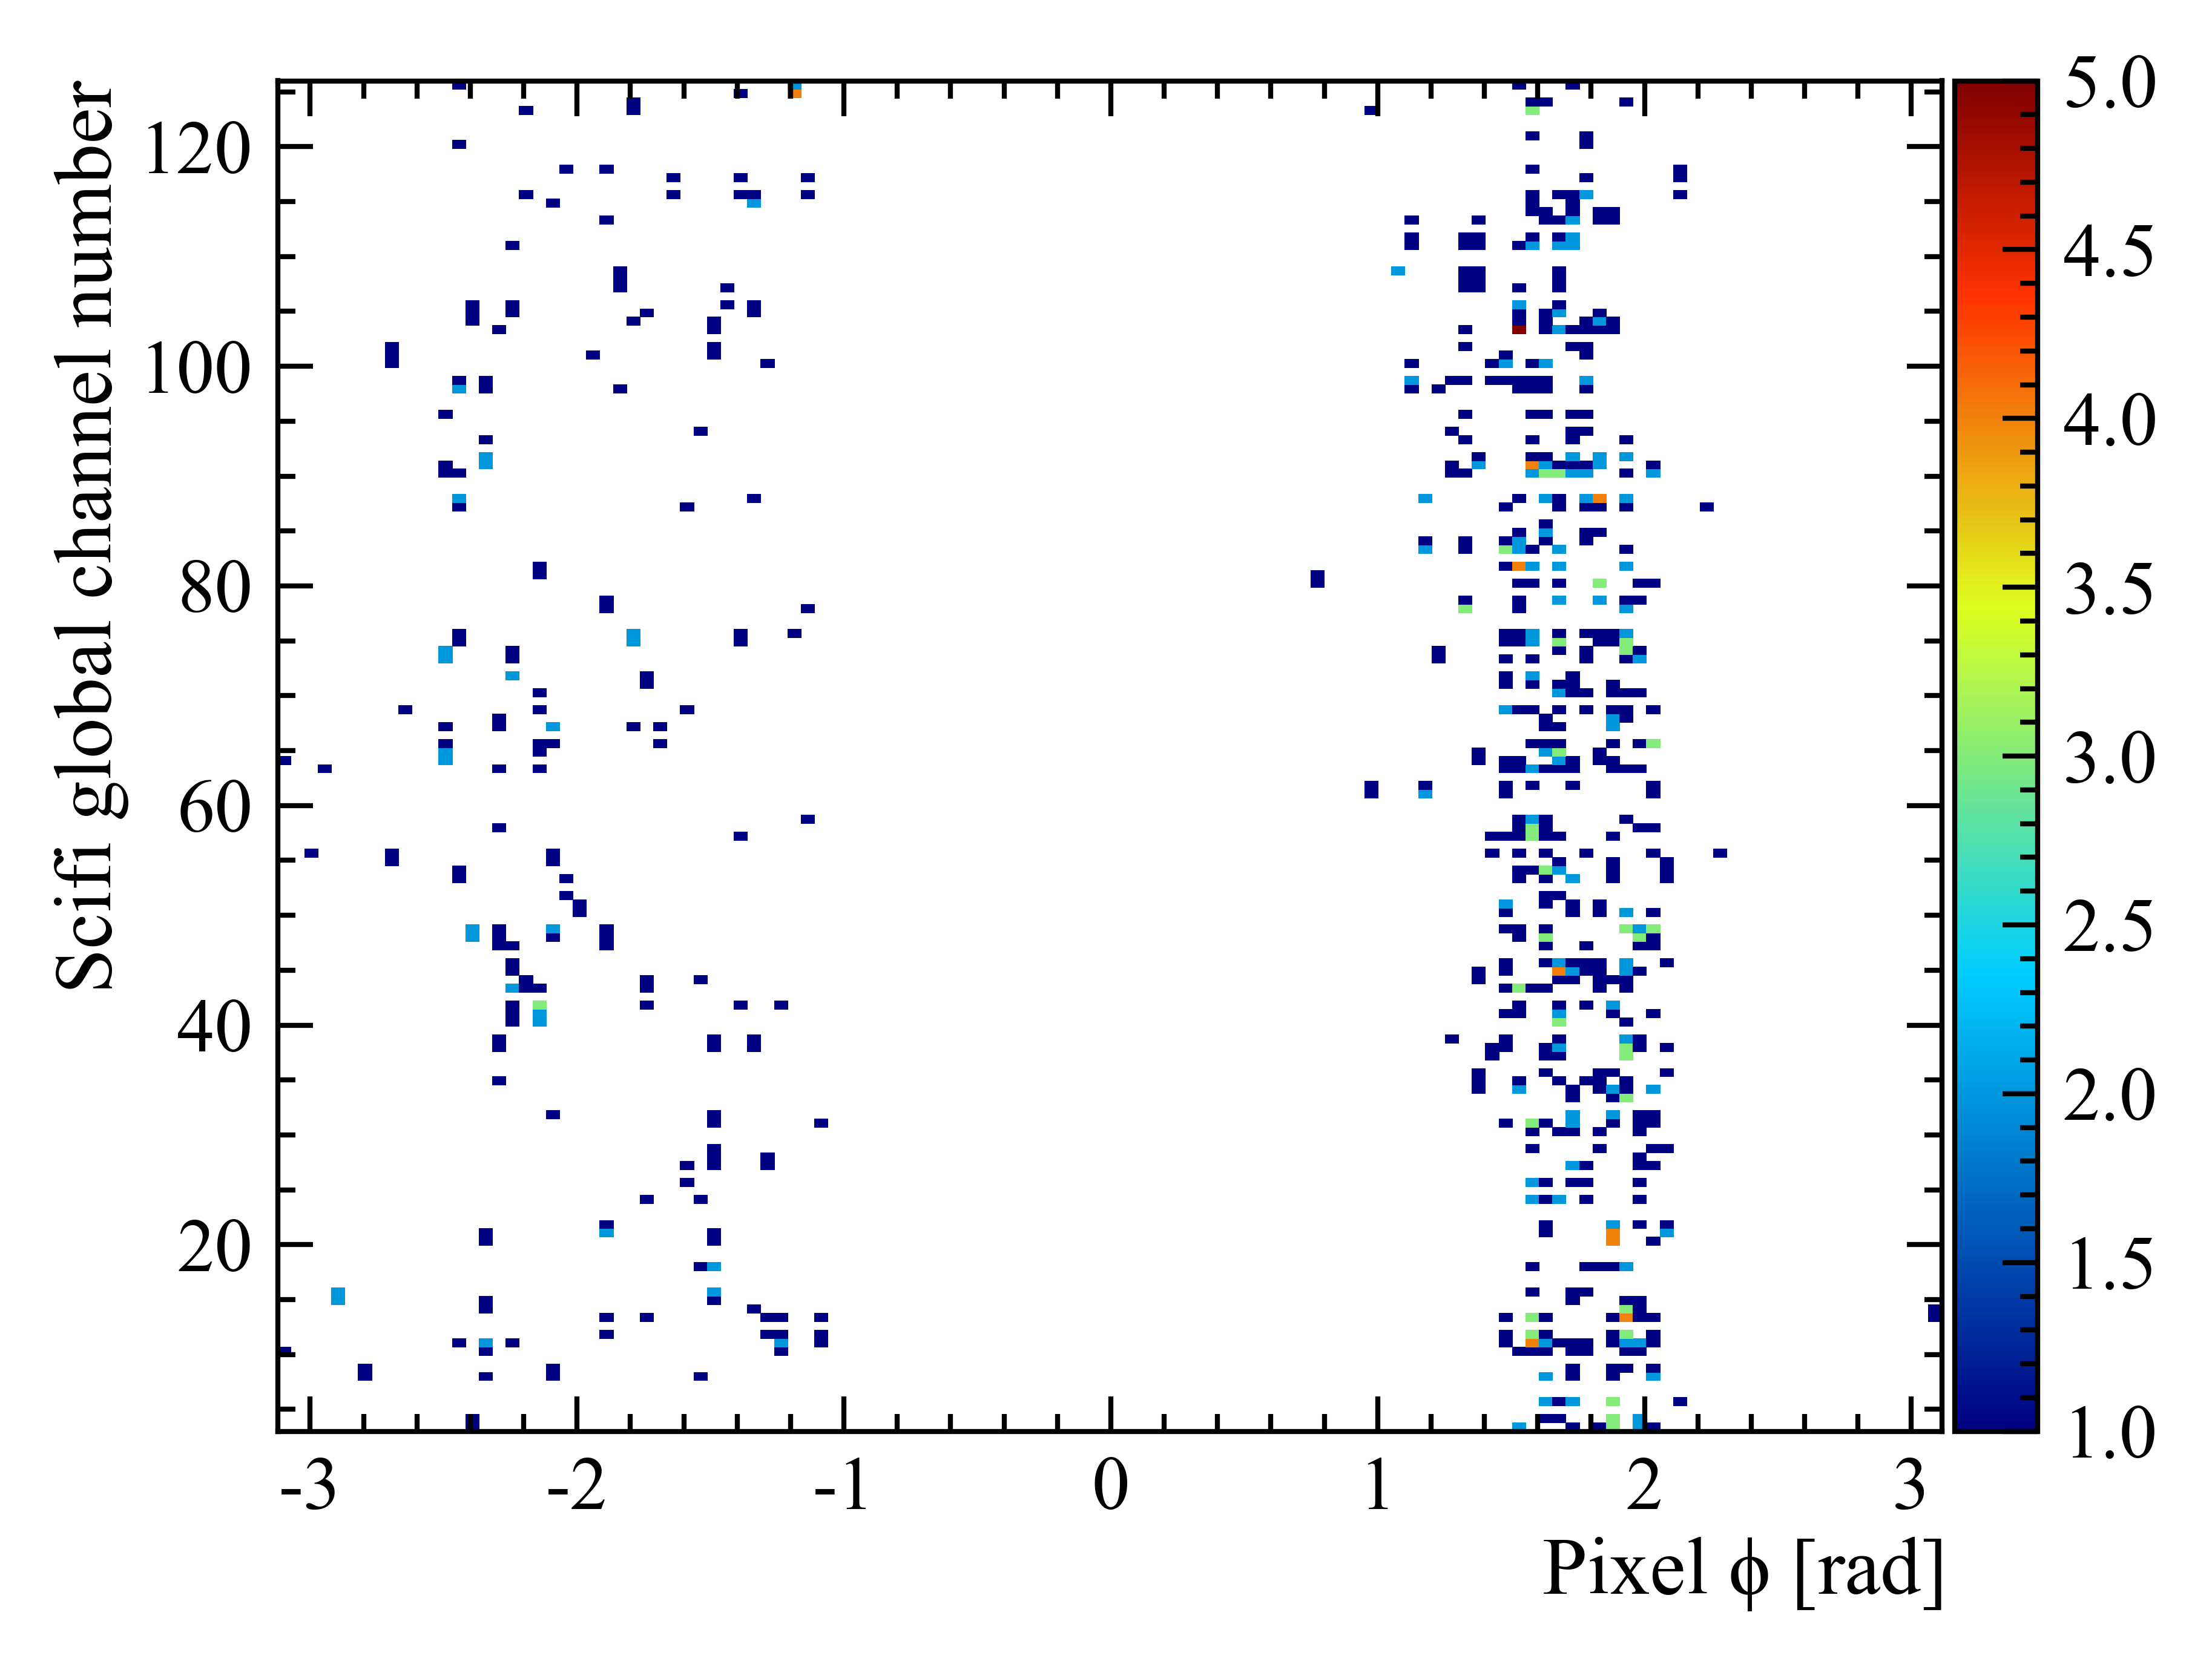

In [32]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["pixel_phi"], df[spat_corr_cut]["global_ch"], bins=[int((df[spat_corr_cut]["pixel_phi"].max()-df[spat_corr_cut]["pixel_phi"].min())/0.05), 4*32 + 32], cmap=MyStyle, cmin=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.07)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi global channel number")
ax.set_xlabel(r"Pixel $\phi$ [rad]")
plt.show()

In [ ]:
fig, ax = plt.subplots()
im0 = ax.hist2d(df[spat_corr_cut]["pixel_z"], df[spat_corr_cut]["global_ch"], bins=[int((df[spat_corr_cut]["pixel_z"].max()-df[spat_corr_cut]["pixel_z"].min())/1), 4*32+32], cmap=MyStyle, cmin=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0[3], cax=cax, orientation='vertical')
ax.set_ylabel("Scifi global channel number")
ax.set_xlabel("Pixel z [mm]")
plt.show()